# Basic Qubit Rotation Example  

In this example, we show how we can use a 
simple gradient descent method to optimize
a unitary gate for qubit rotation. The idea 
is as follows: We start in $|1 \rangle$ state
on a Bloch Sphere and apply rotations around 
Z-Y-Z axes (in that order) using 
$R(\phi,\theta,\omega)$, which is a 
general unitary operator parameterized 
by three real parameters, $\phi$, $\theta$, 
and $\omega$. Each of these parameters represent 
the degree of rotation around x, y and z axes 
respectively to reach the target state, 
which is defined to be $|0 \rangle$ in 
this case. $R(\phi,\theta,\omega)$ has
the following matrix representation:


$$
R(\phi,\theta,\omega) = RZ(\omega)RY(\theta)RZ(\phi)= \begin{bmatrix}
e^{-i(\phi+\omega)/2}\cos(\theta/2) & -e^{i(\phi-\omega)/2}\sin(\theta/2) \\
e^{-i(\phi-\omega)/2}\sin(\theta/2) & e^{i(\phi+\omega)/2}\cos(\theta/2)
\end{bmatrix}
$$

In [128]:
import jax.numpy as jnp
from jax import grad
from jax.random import normal, PRNGKey

import numpy as onp

from qgrad.qgrad_qutip import basis, fidelity

# Visualization
from qutip import Bloch

In [4]:
def rot(phi, theta, omega):
    """Returns a rotation matrix represetning
    the rotation around Z-Y-Z axis.
    
    Parameters:
        phi (float): rotation angle for the
            first rotation around the z-axis     
        theta (float): rotation angle for
            rotation around the y-axis
        omega (float): rotation angle for the 
            second rotation around the z-axis
        
    Returns:
        :obj:`jnp.ndarray`: array representing 
            the rotation matrix 
             
    """

    cos = jnp.cos(theta / 2)
    sin = jnp.sin(theta / 2)

    return jnp.array(
        [
            [
                jnp.exp(-0.5j * (phi + omega)) * cos,
                -(jnp.exp(0.5j * (phi - omega))) * sin,
            ],
            [
                jnp.exp(-0.5j * (phi - omega)) * sin, 
                jnp.exp(0.5j * (phi + omega)) * cos],
            ]
    )

In [15]:
def cost(phi, theta, omega, ket):
    r"""Returns the fidelity between 
    the evolved state and the target 
    :math:`|0 \rangle` state.
    
    Parameters:
        phi (float): rotation angle for the
            first rotation around the z-axis     
        theta (float): rotation angle for
            rotation around the y-axis
        omega (float): rotation angle for the 
            second rotation around the z-axis    
        ket (:obj:`jnp.array`): Initial ket
            to act the rotation matrix on

    Returns:
        float: fidelity between the initial and
            the evolved state under rotation    
    """
    evolved = jnp.dot(rot(phi, theta, omega), ket)
    return fidelity(evolved, basis(2, 0))[0][0]
    #return jnp.absolute(jnp.vdot(evolved.T, basis(2, 0).full()))

## Gradient Ascent Implementation

Here we have our own gradient ascent 
implementation. One may use traditional
gradient descent by subtracting fidelity
from $1$ in the cost function. 

There are multiple 
parameters, like `epochs`, `alpha`, etc, 
that one might tune further in hopes of 
better convergence. For our purposes, however, 
we see that our implementation converges well 
in about $80$ crude steps.

In [129]:
# initialize parameters for learning
epochs = 80
alpha = 0.2  # learning rate
weights = normal(PRNGKey(0), shape=(3,))
init_ket = basis(2, 1) # initial |1> state
der_cost = grad(cost, argnums=[0, 1, 2])
state_hist = [Qobj(onp.array(init_ket))]

for epoch in range(epochs):
    der = jnp.asarray(der_cost(*weights, init_ket))
    weights = weights + alpha * der
    state_hist.append(Qobj(onp.dot(rot(*weights), init_ket)))
    fidel = cost(*weights, init_ket)
    progress = [epoch + 1, fidel]
    if epoch % 10 == 9:
        print("Epoch: {:2f} | Fidelity: {:3f}".format(*jnp.asarray(progress)))

Epoch: 10.000000 | Fidelity: 0.294945
Epoch: 20.000000 | Fidelity: 0.756419
Epoch: 30.000000 | Fidelity: 0.961341
Epoch: 40.000000 | Fidelity: 0.995116
Epoch: 50.000000 | Fidelity: 0.999403
Epoch: 60.000000 | Fidelity: 0.999927
Epoch: 70.000000 | Fidelity: 0.999991
Epoch: 80.000000 | Fidelity: 0.999999


## Bloch Sphere Visualization

As we see above, we started off 
with a very low fidelity 
($\sim$ 0.29). With gradient 
descent iterations, we progressively 
achieve better fidelities via better 
parameters, $\phi$, $\theta$, 
and $\omega$. To visualize training, 
we render our states on to a Bloch sphere
animation below.

We see how our gradient based optimizer 
finds a (nearly) optimal path to 
walk from $|1 \rangle$ (southward) to very 
close to the target state $|0 \rangle$ 
(northward), as desired.

<IPython.core.display.Javascript object>


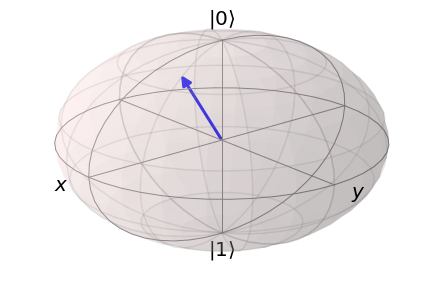

In [131]:
%matplotlib nbagg

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import matplotlib.pyplot as plt

fig = plt.figure()
ax = Axes3D(fig,azim=-40,elev=30)
sphere = Bloch(axes=ax)

def animate(i):
    sphere.clear()
    sphere.add_states(state_hist[i])
    sphere.make_sphere()
    return ax

def init():
    sphere.vector_color = ['b']
    return ax

animation.FuncAnimation(fig, animate, onp.arange(len(state_hist)),
                            init_func=init, repeat=True)